In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data_train = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("/content/drive/MyDrive/fakenews/fakenews/test.tsv", sep="\t", header=None)

data_train[1] = data_train[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})
data_valid[1] = data_valid[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})
data_test[1] = data_test[1].map({"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 2, "mostly-true" : 1, "true" : 1})

In [ ]:
#Viewing sample train data before preprocessing
data_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,1,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,0,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,0,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,2,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,0,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context


 
  # reanming the DataFrame columns
  data_train.rename(columns = { 1 :'label'},
			inplace = True)
  data_valid.rename(columns = { 1 :'label'},
			inplace = True)
  data_test.rename(columns = { 1 :'label'},
			inplace = True)
    
 
  
  
  dataset["sentence"] = dataset[2] #Combining metadata and the text columns into single columns
  
  dataset = dataset.drop([2,3,4,5,6,7,13], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [ ]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train = data_preprocessing(data_train)
data_valid = data_preprocessing(data_valid)
data_test = data_preprocessing(data_test)

In [ ]:
#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,Says the Annies List political group supports ...
1,2,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,2,The economic turnaround started at the end of ...


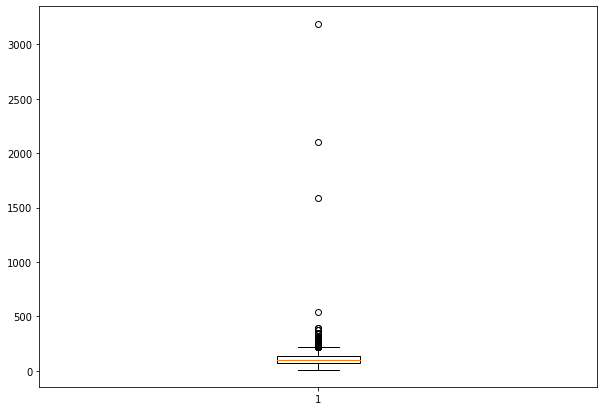

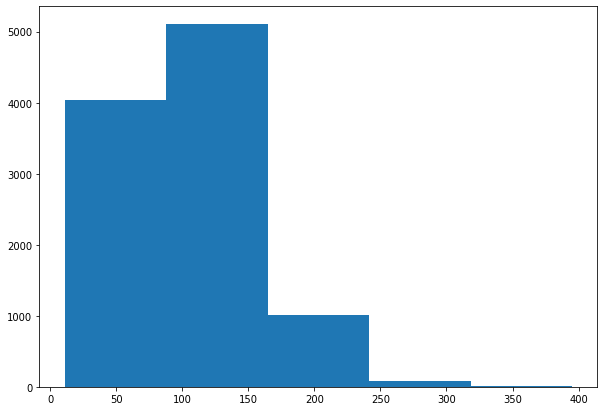

In [ ]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for BERT and RoBERTa

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.8 MB/s eta 0:00:00


In [ ]:
#importing required packages  
from transformers import (
    BertForSequenceClassification,    
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW)

In [ ]:
# Loading BERT base model
bert_model = BertForSequenceClassification.from_pretrained("bert-large-uncased", #Using BERT base model with an uncased vocab.
                                                                num_labels = 3, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                          )
#BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()



In [ ]:
# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-large", #RoBERTa base model
                                                                    num_labels = 3,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-large", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' models loaded')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

 models loaded


In [ ]:
# Print the original sentence.
print(' Original: ', data_train["sentence"][0])

# Split the sentence into tokens - BERT
print('Tokenized BERT: ', bert_tokenizer.tokenize(data_train["sentence"][0]))

# Mapping tokens to token IDs - BERT
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(data_train["sentence"][0])))

# Split the sentence into tokens -RoBERTa
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(data_train["sentence"][0]))

# Mapping tokens to token IDs - RoBERTa
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(data_train["sentence"][0])))

 Original:  Says the Annies List political group supports third-trimester abortions on demand.
Tokenized BERT:  ['says', 'the', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '-', 'trim', '##ester', 'abortion', '##s', 'on', 'demand', '.']
Token IDs BERT:  [2758, 1996, 8194, 2015, 2862, 2576, 2177, 6753, 2353, 1011, 12241, 20367, 11324, 2015, 2006, 5157, 1012]
Tokenized RoBERT:  ['S', 'ays', 'Ġthe', 'ĠAnn', 'ies', 'ĠList', 'Ġpolitical', 'Ġgroup', 'Ġsupports', 'Ġthird', '-', 'tr', 'imester', 'Ġabortions', 'Ġon', 'Ġdemand', '.']
Token IDs RoBERTa:  [104, 4113, 5, 3921, 918, 9527, 559, 333, 4548, 371, 12, 4328, 38417, 17600, 15, 1077, 4]


In [ ]:
#assigning sentences and labels to separate variables
sentences = data_train["sentence"].values
labels = data_train["label"].values

In [ ]:
import torch

In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = dataset["sentence"].values
  labels = dataset["label"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids
      bert_encoded_dict = bert_tokenizer.encode_plus(
                          str(sent),        #sentence              
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 256,     #Since we have seen from our analysis that majority of sentences have length less than 300.    
                          pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.   
                          pad_to_max_length = True,     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
    
      # Add the encoded sentence to the list.    
      bert_input_ids.append(bert_encoded_dict['input_ids'])
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])
      
      
      # Add attention mask to the list 
      bert_attention_masks.append(bert_encoded_dict['attention_mask'])
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
      
      
      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1
      
      
      
  # Convert the lists into tensors.
  bert_input_ids = torch.cat(bert_input_ids, dim=0)
  bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {"Bert":[bert_input_ids, bert_attention_masks, labels], "Roberta":[roberta_input_ids, roberta_attention_masks, labels]}

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(data_train)

bert_input_ids,bert_attention_masks,labels = token_dict_train["Bert"]
roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(data_valid)

bert_input_ids_valid,bert_attention_masks_valid,labels_valid = token_dict_valid["Bert"]
roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)

bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Combine the training inputs into a TensorDataset.
bert_train_dataset = TensorDataset( bert_input_ids, bert_attention_masks, labels) 
roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
bert_val_dataset = TensorDataset(bert_input_ids_valid,bert_attention_masks_valid,labels_valid)
roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

In [ ]:
# Combine the test inputs into a TensorDataset.
bert_test_dataset = TensorDataset(bert_input_ids_test,bert_attention_masks_test,labels_test)
roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoaders for our validation - Loads the data in batches of size 32
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# optimizers - AdamW
# here, i have used default learning rate and epsilon values for both BERT and RoBERTa
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os;

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    #Training 
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
      #Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0: 
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # print current training batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        bert_model.zero_grad()        
        
        outputs = bert_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # model returns a tuple, extract loss value from that tuple
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        
        bert_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    #Validation Part

    
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode    
    bert_model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
           outputs = bert_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,280.    Elapsed: 0:00:52.
  Batch    80  of  1,280.    Elapsed: 0:01:41.
  Batch   120  of  1,280.    Elapsed: 0:02:29.
  Batch   160  of  1,280.    Elapsed: 0:03:18.
  Batch   200  of  1,280.    Elapsed: 0:04:06.
  Batch   240  of  1,280.    Elapsed: 0:04:55.
  Batch   280  of  1,280.    Elapsed: 0:05:44.
  Batch   320  of  1,280.    Elapsed: 0:06:32.
  Batch   360  of  1,280.    Elapsed: 0:07:21.
  Batch   400  of  1,280.    Elapsed: 0:08:09.
  Batch   440  of  1,280.    Elapsed: 0:08:58.
  Batch   480  of  1,280.    Elapsed: 0:09:46.
  Batch   520  of  1,280.    Elapsed: 0:10:35.
  Batch   560  of  1,280.    Elapsed: 0:11:24.
  Batch   600  of  1,280.    Elapsed: 0:12:12.
  Batch   640  of  1,280.    Elapsed: 0:13:01.
  Batch   680  of  1,280.    Elapsed: 0:13:49.
  Batch   720  of  1,280.    Elapsed: 0:14:38.
  Batch   760  of  1,280.    Elapsed: 0:15:26.
  Batch   800  of  1,280.    Elapsed: 0:16:15.
  Batch   840  of

In [ ]:
#Plotting the training loss over epochs
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [ ]:
bert_prediction_sampler = SequentialSampler(bert_test_dataset)
bert_prediction_dataloader = DataLoader(bert_test_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables 
predictions , true_labels = [], []

Predicting labels for 1,267 test sentences...


In [ ]:
# Predict 
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
 
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

              precision    recall  f1-score   support

           0       1.00      0.44      0.61      1267
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.44      1267
   macro avg       0.33      0.15      0.20      1267
weighted avg       1.00      0.44      0.61      1267

[[553   0   0]
 [449   0   0]
 [265   0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [30]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            #Printing current batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        roberta_model.zero_grad()        
        
        outputs = roberta_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # Model returns tuple, extract loss value from that tuple
        loss = outputs[0]
        
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()
        
        roberta_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(roberta_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # Validation
    
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode    
    roberta_model.eval()
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
           
            outputs = roberta_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,280.    Elapsed: 0:00:49.
  Batch    80  of  1,280.    Elapsed: 0:01:36.
  Batch   120  of  1,280.    Elapsed: 0:02:24.
  Batch   160  of  1,280.    Elapsed: 0:03:11.
  Batch   200  of  1,280.    Elapsed: 0:03:58.
  Batch   240  of  1,280.    Elapsed: 0:04:45.
  Batch   280  of  1,280.    Elapsed: 0:05:32.
  Batch   320  of  1,280.    Elapsed: 0:06:20.
  Batch   360  of  1,280.    Elapsed: 0:07:07.
  Batch   400  of  1,280.    Elapsed: 0:07:54.
  Batch   440  of  1,280.    Elapsed: 0:08:41.
  Batch   480  of  1,280.    Elapsed: 0:09:28.
  Batch   520  of  1,280.    Elapsed: 0:10:16.
  Batch   560  of  1,280.    Elapsed: 0:11:03.
  Batch   600  of  1,280.    Elapsed: 0:11:50.
  Batch   640  of  1,280.    Elapsed: 0:12:37.
  Batch   680  of  1,280.    Elapsed: 0:13:24.
  Batch   720  of  1,280.    Elapsed: 0:14:11.
  Batch   760  of  1,280.    Elapsed: 0:14:58.
  Batch   800  of  1,280.    Elapsed: 0:15:45.
  Batch   840  of

In [31]:
roberta_prediction_sampler = SequentialSampler(roberta_test_dataset)
roberta_prediction_dataloader = DataLoader(roberta_test_dataset, sampler=roberta_prediction_sampler, batch_size=batch_size)

In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

Predicting labels for 1,267 test sentences...


In [33]:
# Predict 
for batch in roberta_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


In [34]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

              precision    recall  f1-score   support

           0       1.00      0.44      0.61      1267
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.44      1267
   macro avg       0.33      0.15      0.20      1267
weighted avg       1.00      0.44      0.61      1267

[[553   0   0]
 [449   0   0]
 [265   0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
